<a href="https://colab.research.google.com/github/Sirfowahid/SPT-SoilTypeAnalysis/blob/main/SPT_%26_SoilType_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Dataset

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,auc,roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
torch.manual_seed(0)
np.random.seed(42)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Projects/10. SPT and Soil Type analysis/Stp and soil type.xlsx")

In [ ]:
data.head()

,SPT,SoilType,X,Y,Z,Borehole
0,8,SM,155914.155,255309.835,0.0,BH1
1,11,SM,155914.155,255309.835,1.0,BH1
2,10,SM,155914.155,255309.835,2.0,BH1
3,9,SM,155914.155,255309.835,3.0,BH1
4,12,SM,155914.155,255309.835,4.0,BH1


# Performing EDA

In [ ]:
data.dropna(inplace=True)

In [ ]:
len(data.SoilType.unique())

10

In [ ]:
data.isna().sum()

SPT         0
SoilType    0
X           0
Y           0
Z           0
Borehole    0
dtype: int64

In [ ]:
lencod = LabelEncoder()
data['Label'] = lencod.fit_transform(data.SoilType)

In [ ]:
features = data[['X','Y','Z']]
target1 = data['SPT']
target2 = data['Label']

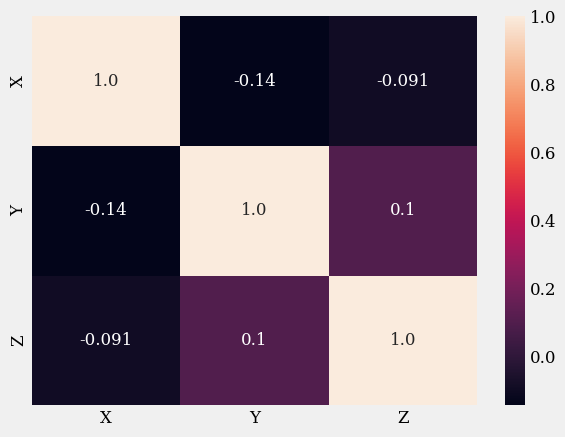

In [ ]:
sns.heatmap(features.corr(),annot=True,fmt='0.2')
plt.show()

In [ ]:
x_train,x_test,y1_train,y1_test,y2_train,y2_test = train_test_split(features,target1,target2,test_size=0.2,random_state=42,stratify=target2)

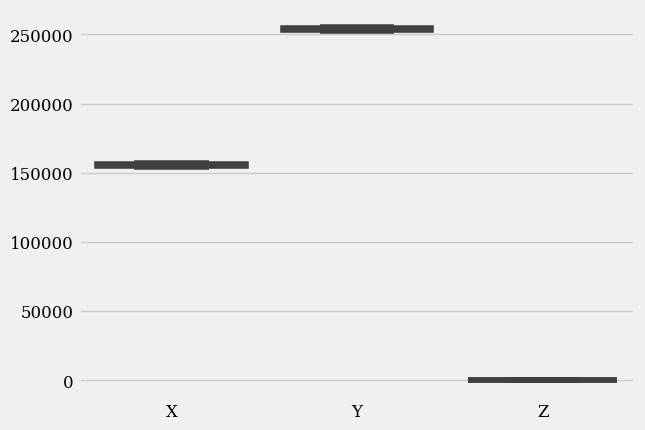

In [ ]:
sns.boxplot(x_train)
plt.show()

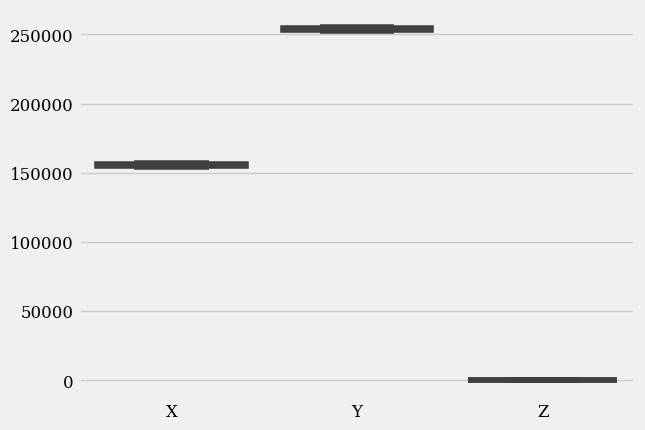

In [ ]:
sns.boxplot(x_test)
plt.show()

In [ ]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

In [ ]:
x_std = scaler.transform(features)

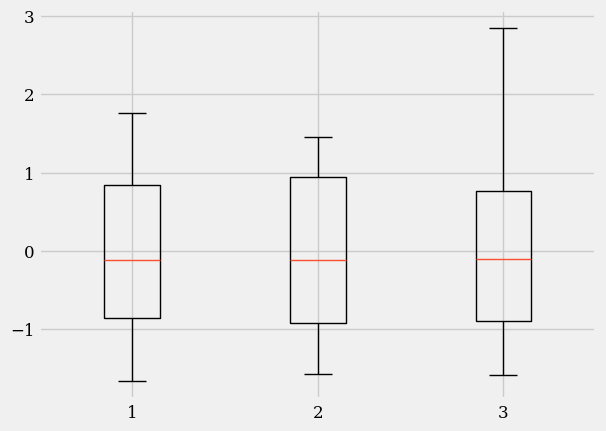

In [ ]:
plt.boxplot(x_std)
plt.show()

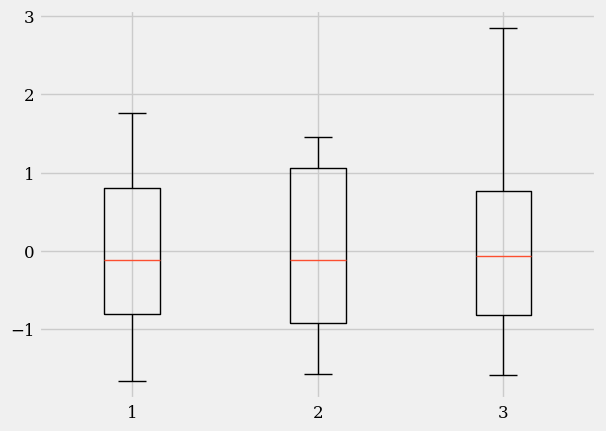

In [ ]:
plt.boxplot(x_train_std)
plt.show()

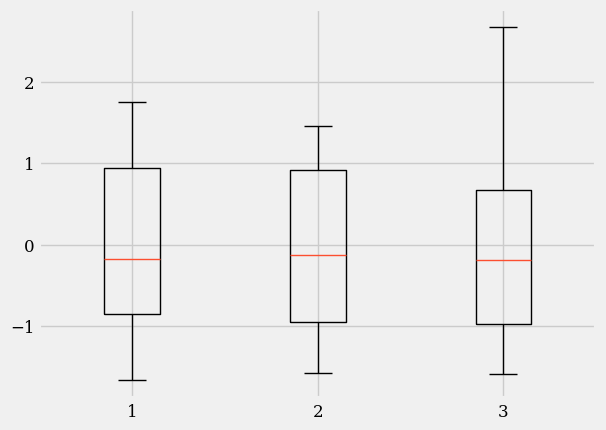

In [ ]:
plt.boxplot(x_test_std)
plt.show()

# Experiment and Analysis with ANN

In [ ]:
EPOCHS = 2000
LR = 0.005

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 64)
        self.output1 = nn.Linear(64, 1)
        self.output2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.output1(x)
        out2 = self.output2(x)
        return out1, out2


In [ ]:
input_size = 3
linear_model = LinearModel(input_size)

In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=LR)

In [ ]:
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_std, dtype=torch.float32),
                                               torch.tensor(y1_train.values, dtype=torch.float32),
                                               torch.tensor(y2_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_loader_ = DataLoader(train_dataset, batch_size=len(x_train_std), shuffle=True)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_test_std,dtype=torch.float32),
    torch.tensor(y1_test.values,dtype=torch.float32),
    torch.tensor(y2_test.values,dtype=torch.long)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,shuffle=True,batch_size=len(x_test)
)

In [ ]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_std,dtype=torch.float32),
    torch.tensor(target1.values,dtype=torch.float32),
    torch.tensor(target2.values,dtype=torch.long)
)
data_loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size)

In [ ]:
for x,y,z in train_loader:
  break
p = linear_model(x)
print(p[0].shape)
print(p[1].shape)

torch.Size([64, 1])
torch.Size([64, 10])


In [ ]:
epochs = EPOCHS
losses = []
losses1 = []
losses2 = []
for epoch in range(epochs):
    loss = []
    loss1 = []
    loss2 = []
    for x,y1,y2 in data_loader:
        p1,p2 = linear_model(x)
        lf1 = criterion1(p1,y1.unsqueeze(1))
        loss1.append(lf1.item())
        lf2 = criterion2(p2,y2)
        loss2.append(lf2.item())
        tl = lf1+lf2
        loss.append(tl.item())
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
    losses.append(np.mean(loss))
    losses1.append(np.mean(loss1))
    losses2.append(np.mean(loss2))
    if((epoch+1)%100==0):
        for x,y,z in test_loader:
            p = linear_model(x)
            reg = p[0].squeeze()
        r2 = r2_score(reg.detach().numpy(),y.numpy())
        for x,y,z in test_loader:
            p = linear_model(x)
            cls = p[1]
        pred = torch.argmax(cls,axis=1)
        print(f'epoch:{epoch+1} has loss of: {np.mean(loss)}')
        print(f'reg acc: {r2}')
        print(f'cls acc:{(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
        print()


epoch:100 has loss of: 43.709733554295134
reg acc: 0.8560263947817551
cls acc:0.6716417910447762

epoch:200 has loss of: 30.862011591593426
reg acc: 0.900884816779951
cls acc:0.7425373134328358

epoch:300 has loss of: 22.07399842852638
reg acc: 0.8649823102429358
cls acc:0.7686567164179104

epoch:400 has loss of: 18.27985773767744
reg acc: 0.9101306489907878
cls acc:0.8414179104477612

epoch:500 has loss of: 15.645865167890276
reg acc: 0.9355559330145761
cls acc:0.8246268656716418

epoch:600 has loss of: 11.888056493940807
reg acc: 0.943916251680023
cls acc:0.8619402985074627

epoch:700 has loss of: 9.532252095994496
reg acc: 0.9517406929096419
cls acc:0.878731343283582

epoch:800 has loss of: 14.43570515655336
reg acc: 0.9369626278122647
cls acc:0.878731343283582

epoch:900 has loss of: 12.619353385198684
reg acc: 0.9310031649988527
cls acc:0.871268656716418

epoch:1000 has loss of: 9.860888123512268
reg acc: 0.9688894545201089
cls acc:0.9011194029850746

epoch:1100 has loss of: 21.59

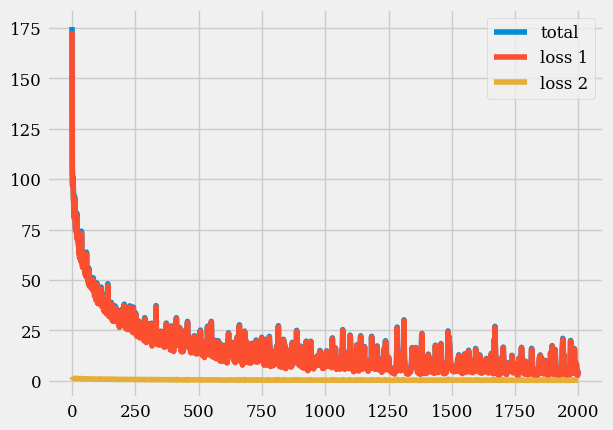

In [ ]:
plt.plot(losses)
plt.plot(losses1)
plt.plot(losses2)
plt.legend(['total','loss 1','loss 2'])
plt.savefig('ann loss.png')
plt.show()

In [ ]:
def evaluation(loader,model):
  for x,y,z in loader:
    pass
  print("Final Evaluation:")
  print("####################################################")

  train_p = model(x)
  print('Regression Evaluation')
  print('*************************************')
  print(f'R2 Score: {r2_score(train_p[0].detach().numpy(),y)}')
  print(f'MAE Score: {mean_absolute_error(train_p[0].detach().numpy(),y)}')
  print(f'MSE Score: {mean_squared_error(train_p[0].detach().numpy(),y)}')
  print(f'Actual STD: {np.std(y.numpy())}')
  print(f'Predicted STD: {np.std(train_p[0].detach().numpy())}')
  print('*************************************')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  pred = torch.argmax(train_p[1],axis=1)
  print('Classification Evaluation')
  print(f'Cls Accuracy: {(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
  print(f'Classification Report:')
  print(classification_report(pred,z))
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print()
  print('########################################################')

  cm = confusion_matrix(pred,z)
  sns.heatmap(cm,annot=True,fmt='0')
  plt.savefig('confusion matrix.svg')
  plt.show()

  sns.regplot(x=train_p[0].squeeze().detach().numpy(), y=y.numpy(), ci=None, line_kws={'color': 'red','linewidth':3},marker='o',color='black')
  plt.savefig('')
  plt.show()

Final Evaluation:
####################################################
Regression Evaluation
*************************************
R2 Score: 0.9851270388611292
MAE Score: 1.1933304071426392
MSE Score: 3.480149030685425
Actual STD: 15.910208702087402
Predicted STD: 15.296786308288574
*************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Classification Evaluation
Cls Accuracy: 0.9472947761194029
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.90      0.91      0.91       352
           2       1.00      1.00      1.00         3
           3       0.83      0.83      0.83         6
           4       0.92      0.93      0.93       331
           5       1.00      1.00      1.00        14
           6       0.97      0.96      0.97      1126
           7       0.92      0.95      0.94       200
           8       1.00      1.00      1.00        36
           9     

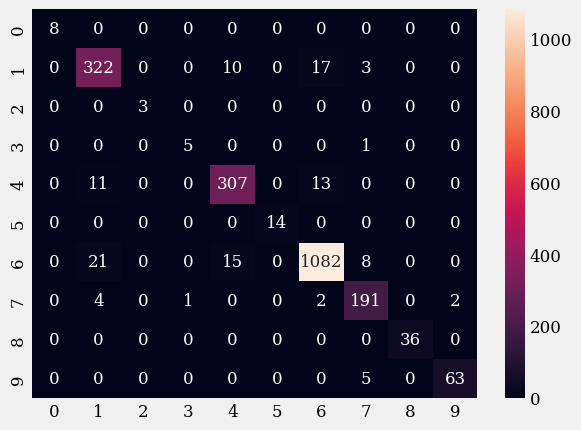

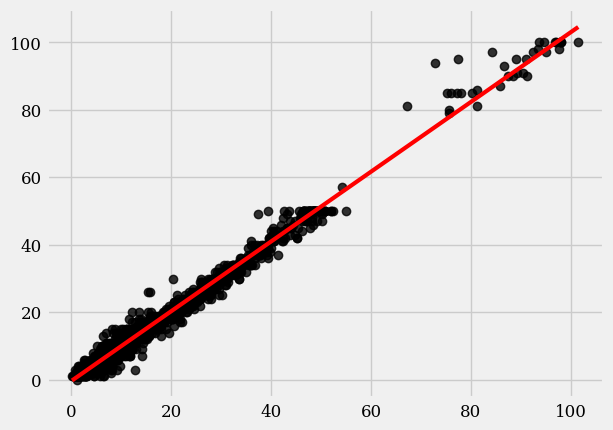

In [ ]:
evaluation(train_loader_,linear_model)

Final Evaluation:
####################################################
Regression Evaluation
*************************************
R2 Score: 0.9854157973478478
MAE Score: 1.135062336921692
MSE Score: 3.025371551513672
Actual STD: 14.97571086883545
Predicted STD: 14.40283489227295
*************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Classification Evaluation
Cls Accuracy: 0.9477611940298507
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.96      0.88      0.91        98
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.89      0.93      0.91        80
           5       1.00      0.80      0.89         5
           6       0.96      0.98      0.97       274
           7       0.92      1.00      0.96        48
           8       0.89      1.00      0.94         8
           9       1

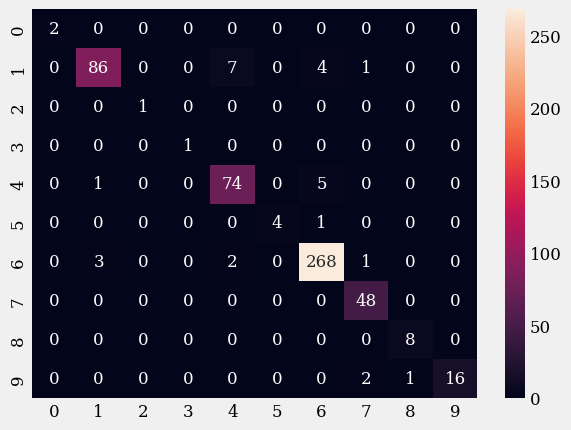

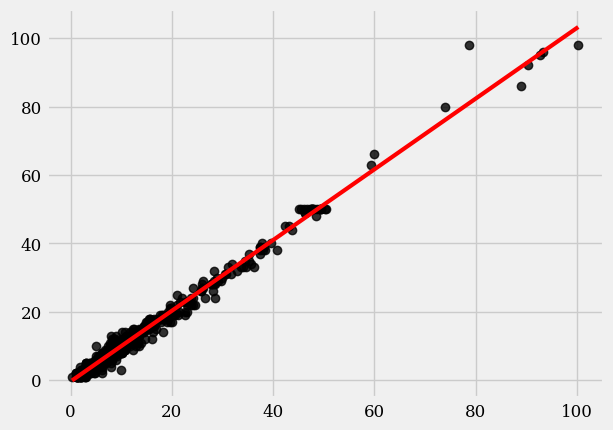

In [ ]:
evaluation(test_loader,linear_model)

# Experiment and Analysis with CNN

In [ ]:
EPOCHS = 2000
LR = 0.005

In [ ]:
n_sample,n_features = x_train_std.shape
print(x_train_std.shape)
x_train_std = x_train_std.reshape((n_sample,n_features,1))
print(x_train_std.shape)

(2144, 3)
(2144, 3, 1)


In [ ]:
x_train.shape

(2144, 3)

In [ ]:
n_sample,n_features = x_test_std.shape
print(x_test_std.shape)
x_test_std = x_test_std.reshape((n_sample,n_features,1))
print(x_test_std.shape)

(536, 3)
(536, 3, 1)


In [ ]:
n_sample,n_features = x_std.shape
print(x_std.shape)
x_std = x_std.reshape((n_sample,n_features,1))
print(x_std.shape)

(2680, 3)
(2680, 3, 1)


In [ ]:
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train_std,dtype=torch.float32),
    torch.tensor(y1_train.values,dtype=torch.float32),
    torch.tensor(y2_train.values,dtype=torch.long)
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,shuffle=True,batch_size=batch_size
)

In [ ]:
train_loader_ = DataLoader(train_dataset, batch_size=len(x_train_std), shuffle=True)

In [ ]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_std,dtype=torch.float32),
    torch.tensor(target1.values,dtype=torch.float32),
    torch.tensor(target2.values,dtype=torch.long)
)
data_loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_test_std,dtype=torch.float32),
    torch.tensor(y1_test.values,dtype=torch.float32),
    torch.tensor(y2_test.values,dtype=torch.long)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,shuffle=True,batch_size=len(x_test)
)

In [ ]:

class Conv1DModel(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size):
        super(Conv1DModel, self).__init__()

        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.conv_output_size = num_filters
        self.fc1 = nn.Linear(self.conv_output_size, 128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 64)
        self.output1 = nn.Linear(64, 1)
        self.output2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.output1(x)
        out2 = self.output2(x)
        return out1, out2

conv_model = Conv1DModel(3,128,1)
print(conv_model)

Conv1DModel(
  (conv1d): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (output1): Linear(in_features=64, out_features=1, bias=True)
  (output2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=LR)

In [ ]:
epochs = EPOCHS
losses = []
losses1 = []
losses2 = []
for epoch in range(epochs):
    loss = []
    loss1 = []
    loss2 = []
    for x,y1,y2 in data_loader:
        p1,p2 = conv_model(x)
        lf1 = criterion1(p1,y1.unsqueeze(1))
        loss1.append(lf1.item())
        lf2 = criterion2(p2,y2)
        loss2.append(lf2.item())
        tl = lf1+lf2
        loss.append(tl.item())
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
    losses.append(np.mean(loss))
    losses1.append(np.mean(loss1))
    losses2.append(np.mean(loss2))
    if((epoch+1)%100==0):
        for x,y,z in test_loader:
            p = conv_model(x)
            reg = p[0].squeeze()
        r2 = r2_score(reg.detach().numpy(),y.numpy())
        for x,y,z in test_loader:
            p = conv_model(x)
            cls = p[1]
        pred = torch.argmax(cls,axis=1)
        print(f'epoch:{epoch+1} has loss of: {np.mean(loss)}')
        print(f'reg acc: {r2}')
        print(f'cls acc:{(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
        print()


epoch:100 has loss of: 52.72991026015509
reg acc: 0.7720499693229254
cls acc:0.6529850746268657

epoch:200 has loss of: 37.31924445288522
reg acc: 0.857945078702685
cls acc:0.7332089552238806

epoch:300 has loss of: 32.60291658129011
reg acc: 0.8341690611228383
cls acc:0.8302238805970149

epoch:400 has loss of: 20.17502436183748
reg acc: 0.9328010620850202
cls acc:0.8470149253731343

epoch:500 has loss of: 21.549962634132022
reg acc: 0.9124573609084773
cls acc:0.7947761194029851

epoch:600 has loss of: 19.754703873679752
reg acc: 0.9412025525499088
cls acc:0.8656716417910447

epoch:700 has loss of: 17.918184677759807
reg acc: 0.9225120384775191
cls acc:0.8582089552238806

epoch:800 has loss of: 13.927915209815616
reg acc: 0.9446359090862599
cls acc:0.8395522388059702

epoch:900 has loss of: 19.300148248672485
reg acc: 0.9458904441687868
cls acc:0.8339552238805971

epoch:1000 has loss of: 5.760654469331105
reg acc: 0.968926296030961
cls acc:0.9085820895522388

epoch:1100 has loss of: 11

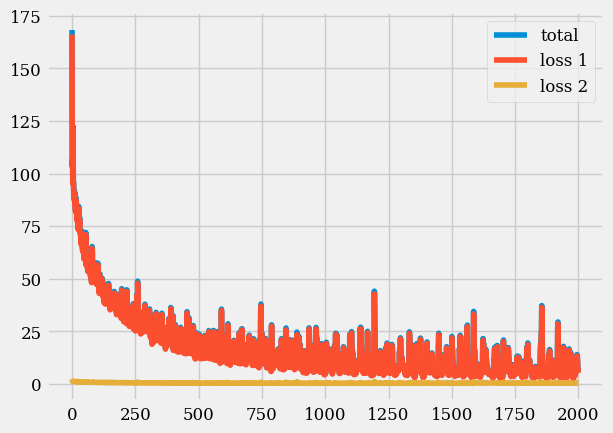

In [ ]:
plt.plot(losses)
plt.plot(losses1)
plt.plot(losses2)
plt.legend(['total','loss 1','loss 2'])
plt.savefig('cnn loss.png')
plt.show()

Final Evaluation:
####################################################
Regression Evaluation
*************************************
R2 Score: 0.9826482030050041
MAE Score: 1.322575569152832
MSE Score: 4.583662033081055
Actual STD: 15.910208702087402
Predicted STD: 16.253019332885742
*************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Classification Evaluation
Cls Accuracy: 0.8339552238805971
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.79      0.88      0.83       319
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.80      0.85      0.83       313
           5       0.86      0.92      0.89        13
           6       0.93      0.84      0.88      1231
           7       0.47      0.70      0.56       139
           8       0.97      0.97      0.97        36
           9      

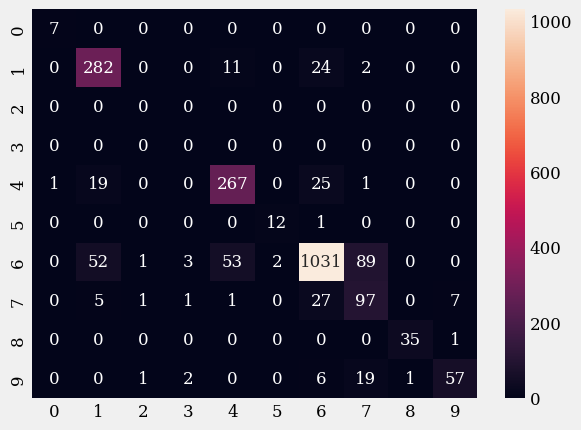

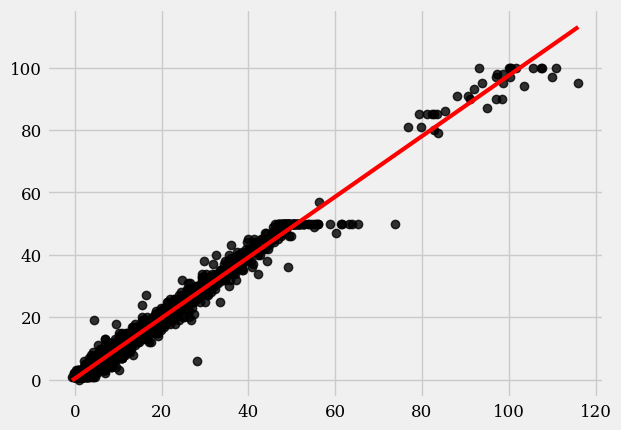

In [ ]:
evaluation(train_loader_,conv_model)

Final Evaluation:
####################################################
Regression Evaluation
*************************************
R2 Score: 0.9837046951029575
MAE Score: 1.2790255546569824
MSE Score: 3.615687608718872
Actual STD: 14.975711822509766
Predicted STD: 14.89581298828125
*************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Classification Evaluation
Cls Accuracy: 0.871268656716418
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.89      0.94      0.91        85
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.86      0.90      0.88        79
           5       1.00      1.00      1.00         4
           6       0.97      0.85      0.91       316
           7       0.33      0.81      0.47        21
           8       0.78      1.00      0.88         7
           9       

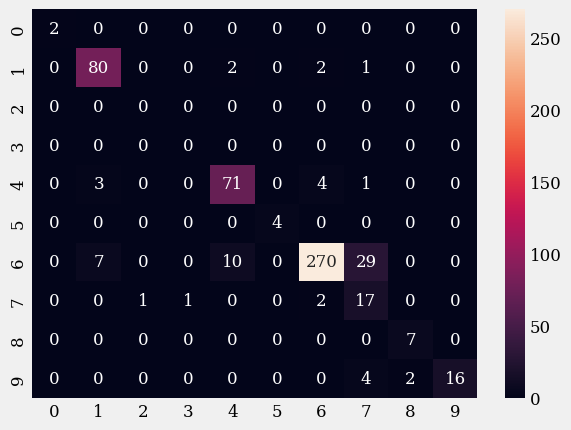

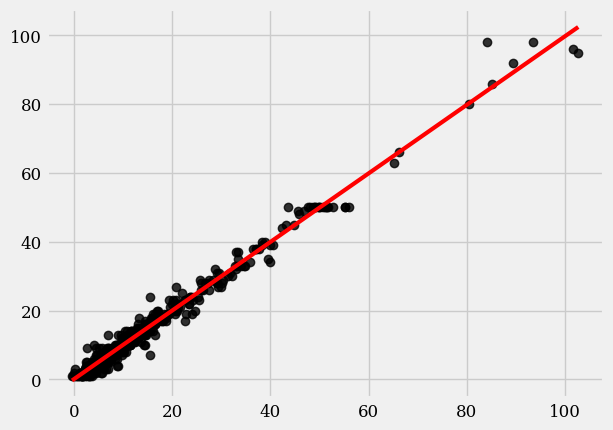

In [ ]:
evaluation(test_loader,conv_model)

# Experiment and Analysis with LSTM

In [ ]:
EPOCHS = 2000
LR = 0.005

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 64)
        self.output1 = nn.Linear(64, 1)
        self.output2 = nn.Linear(64, 10)

    def forward(self, x):

        lstm_out, _ = self.lstm(x)

        lstm_out = lstm_out[:, -1, :]

        x = torch.relu(self.fc1(lstm_out))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.output1(x)
        out2 = self.output2(x)
        return out1, out2

input_size = 3
hidden_size = 128
num_layers = 2

lstm_model = LSTMModel(input_size, hidden_size, num_layers)


In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)

In [ ]:
x,y,z = next(iter(train_loader))

In [ ]:
x.shape

torch.Size([64, 3, 1])

In [ ]:
p = lstm_model(x.permute(0,2,1))

In [ ]:
p[1].shape

torch.Size([64, 10])

In [ ]:
def evaluation_rnn(loader,model):
  for x,y,z in loader:
    pass
  print("Final Evaluation:")
  print("####################################################")

  train_p = model(x.permute(0,2,1))
  print('Regression Evaluation')
  print('*************************************')
  print(f'R2 Score: {r2_score(train_p[0].detach().numpy(),y)}')
  print(f'MAE Score: {mean_absolute_error(train_p[0].detach().numpy(),y)}')
  print(f'MSE Score: {mean_squared_error(train_p[0].detach().numpy(),y)}')
  print(f'Actual STD: {np.std(y.numpy())}')
  print(f'Predicted STD: {np.std(train_p[0].detach().numpy())}')
  print('*************************************')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  pred = torch.argmax(train_p[1],axis=1)
  print('Classification Evaluation')
  print(f'Cls Accuracy: {(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
  print(f'Classification Report:')
  print(classification_report(pred,z))
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print()
  print('########################################################')

  cm = confusion_matrix(pred,z)
  sns.heatmap(cm,annot=True,fmt='0')
  plt.savefig('confusion matrix.svg')
  plt.show()

  sns.regplot(x=train_p[0].squeeze().detach().numpy(), y=y.numpy(), ci=None, line_kws={'color': 'red','linewidth':3},marker='o',color='black')
  plt.savefig('')
  plt.show()

In [ ]:
epochs = EPOCHS
losses = []
losses1 = []
losses2 = []
for epoch in range(epochs):
    loss = []
    loss1 = []
    loss2 = []
    for x,y1,y2 in train_loader:
        p1,p2 = lstm_model(x.permute(0,2,1))
        lf1 = criterion1(p1,y1.unsqueeze(1))
        loss1.append(lf1.item())
        lf2 = criterion2(p2,y2)
        loss2.append(lf2.item())
        tl = lf1+lf2
        loss.append(tl.item())
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
    losses.append(np.mean(loss))
    losses1.append(np.mean(loss1))
    losses2.append(np.mean(loss2))
    for x,y,z in test_loader:
        p = lstm_model(x.permute(0,2,1))
        reg = p[0].squeeze()
    if((epoch+1)%100==0):
        for x,y,z in test_loader:
            p = lstm_model(x.permute(0,2,1))
            reg = p[0].squeeze()
        r2 = r2_score(reg.detach().numpy(),y.numpy())
        for x,y,z in test_loader:
            p = lstm_model(x.permute(0,2,1))
            cls = p[1]
        pred = torch.argmax(cls,axis=1)
        print(f'epoch:{epoch+1} has loss of: {np.mean(loss)}')
        print(f'reg acc: {r2}')
        print(f'cls acc:{(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
        print()


epoch:100 has loss of: 45.221412041608026
reg acc: 0.7598716454276032
cls acc:0.6492537313432836

epoch:200 has loss of: 24.64080799327177
reg acc: 0.7550401343920556
cls acc:0.7089552238805971

epoch:300 has loss of: 13.399635314941406
reg acc: 0.7545755605053373
cls acc:0.7555970149253731

epoch:400 has loss of: 17.901394675759708
reg acc: 0.7681748259623996
cls acc:0.7481343283582089

epoch:500 has loss of: 10.941004602348103
reg acc: 0.7863094855336146
cls acc:0.7723880597014925

epoch:600 has loss of: 7.537896135274102
reg acc: 0.7394951928144164
cls acc:0.75

epoch:700 has loss of: 3.009284587467418
reg acc: 0.7970038669226727
cls acc:0.7947761194029851

epoch:800 has loss of: 3.5404030750779545
reg acc: 0.7712851134599926
cls acc:0.789179104477612

epoch:900 has loss of: 2.813090815263636
reg acc: 0.7559436253509854
cls acc:0.789179104477612

epoch:1000 has loss of: 6.233815613914938
reg acc: 0.6909341564469041
cls acc:0.7947761194029851

epoch:1100 has loss of: 3.16488152216462

In [ ]:
for x,y,z in test_loader:
    p = lstm_model(x.permute(0,2,1))
    reg = p[0].squeeze()
r2_score(reg.detach().numpy(),y.numpy())

0.6595026277357243

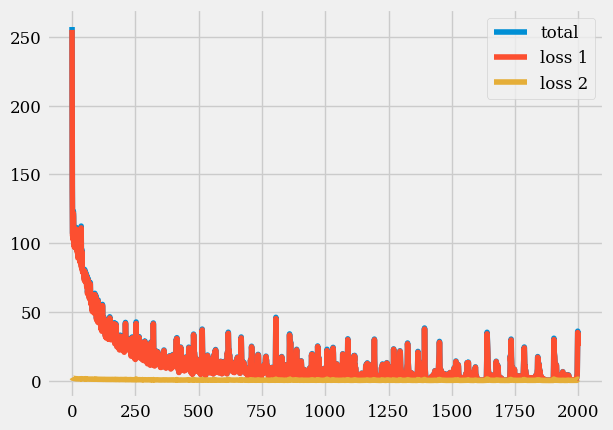

In [ ]:
plt.plot(losses)
plt.plot(losses1)
plt.plot(losses2)
plt.legend(['total','loss 1','loss 2'])
plt.savefig('lstm loss.png')
plt.show()

# Experiment and Analysis with GRU

In [ ]:
EPOCHS = 2000
LR = 0.005

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 64)
        self.output1 = nn.Linear(64, 1)
        self.output2 = nn.Linear(64, 10)

    def forward(self, x):

        gru_out, _ = self.gru(x)

        gru_out = gru_out[:, -1, :]

        x = torch.relu(self.fc1(gru_out))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.output1(x)
        out2 = self.output2(x)
        return out1, out2

input_size = 3
hidden_size = 128
num_layers = 2

gru_model = GRUModel(input_size, hidden_size, num_layers)


In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LR)

In [ ]:
x,y,z = next(iter(train_loader))

In [ ]:
epochs = EPOCHS
losses = []
losses1 = []
losses2 = []
for epoch in range(epochs):
    loss = []
    loss1 = []
    loss2 = []
    for x,y1,y2 in train_loader:
        p1,p2 = gru_model(x.permute(0,2,1))
        lf1 = criterion1(p1,y1.unsqueeze(1))
        loss1.append(lf1.item())
        lf2 = criterion2(p2,y2)
        loss2.append(lf2.item())
        tl = lf1+lf2
        loss.append(tl.item())
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
    losses.append(np.mean(loss))
    losses1.append(np.mean(loss1))
    losses2.append(np.mean(loss2))
    for x,y,z in test_loader:
        p = gru_model(x.permute(0,2,1))
        reg = p[0].squeeze()
    if((epoch+1)%100==0):
        for x,y,z in test_loader:
            p = gru_model(x.permute(0,2,1))
            reg = p[0].squeeze()
        r2 = r2_score(reg.detach().numpy(),y.numpy())
        for x,y,z in test_loader:
            p = gru_model(x.permute(0,2,1))
            cls = p[1]
        pred = torch.argmax(cls,axis=1)
        print(f'epoch:{epoch+1} has loss of: {np.mean(loss)}')
        print(f'reg acc: {r2}')
        print(f'cls acc:{(pred.detach().numpy()==z.numpy()).sum()/len(z)}')
        print()


epoch:100 has loss of: 50.690664908465216
reg acc: 0.6909158600023304
cls acc:0.628731343283582

epoch:200 has loss of: 25.260173489065732
reg acc: 0.7615711985109749
cls acc:0.7220149253731343

epoch:300 has loss of: 16.155157734366025
reg acc: 0.7895357918628007
cls acc:0.789179104477612

epoch:400 has loss of: 13.448766063241397
reg acc: 0.7883154164623323
cls acc:0.8078358208955224

epoch:500 has loss of: 10.918997638365802
reg acc: 0.806137327984377
cls acc:0.8022388059701493

epoch:600 has loss of: 6.803498906247756
reg acc: 0.8153965631001532
cls acc:0.8134328358208955

epoch:700 has loss of: 8.519200928070966
reg acc: 0.8182749139822306
cls acc:0.8059701492537313

epoch:800 has loss of: 4.595019287922803
reg acc: 0.8246604136721519
cls acc:0.832089552238806

epoch:900 has loss of: 7.98174865806804
reg acc: 0.6744818250886714
cls acc:0.8115671641791045

epoch:1000 has loss of: 3.937265967621523
reg acc: 0.7933499065353072
cls acc:0.8059701492537313

epoch:1100 has loss of: 2.131

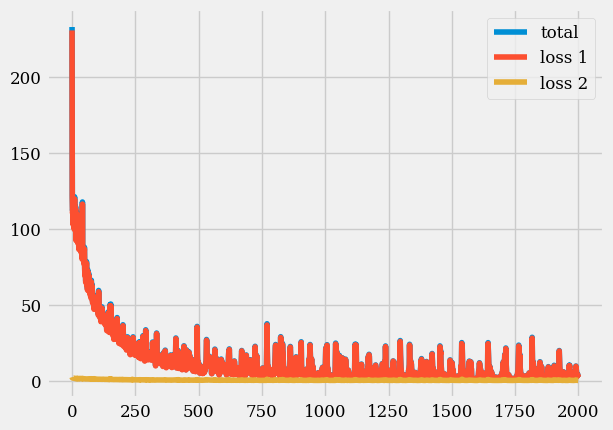

In [ ]:
plt.plot(losses)
plt.plot(losses1)
plt.plot(losses2)
plt.legend(['total','loss 1','loss 2'])
plt.savefig('gru loss.png')
plt.show()